In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Exercise 1

For this problem, it's useful to make use of a Python `class`[(see here)](https://docs.python.org/3/tutorial/classes.html) to encapsulate the simulation data and define methods for the finite difference update and boundary conditions. We do not need to store the `T` from a previous time-step as we can use the `+=` operator on the current `T`.

In [2]:
class thermal_simulation:
    """Class for a thermal simulation"""
    def __init__(self, T0, dx, dt):
        """Initialize the simulation
        
        Arguments:
            T0    initial 1D array of temperatures
            dx    spatial step
            dt    time step
        """
        self.T = np.copy(T0)
        self.dx = dx
        self.dt = dt
        self.eta = dt/dx**2

        self.boundary_condition()

    def update(self):
        """Update the simulation one time step using finite difference"""
        grad_T = np.roll(self.T,1) + np.roll(self.T,-1) - 2*self.T
        self.T += self.eta*grad_T
        self.boundary_condition()

    def boundary_condition(self):
        """Enforce the boundary condition"""
        self.T[0] = 0
        self.T[-1] = 0

We can then use this simulation class to update our initial condition over $N_\text{steps}$, and store the temperature as a function of time:

In [3]:
# Initialize a grid with T = 100
Ngrid = 100
T0 = 100*np.ones(Ngrid, dtype=float)

# simulation instance
sim = thermal_simulation(T0, dx=1, dt=.3)

# array to store T over time
T_store = []
store_every = 10

# run simulation for Nsteps
Nsteps = 12000
for i in range(Nsteps):
    sim.update()
    if i % store_every == 0:
        T_store.append(np.copy(sim.T))

T_store = np.array(T_store)

We can then visualize the stored temperature data in a number of ways; as a 3D surface plot or 2D contours of constant temperature:

[Text(0.5, 0, 'temperature'), Text(0.5, 0, 'X'), Text(0.5, 0, 'time')]

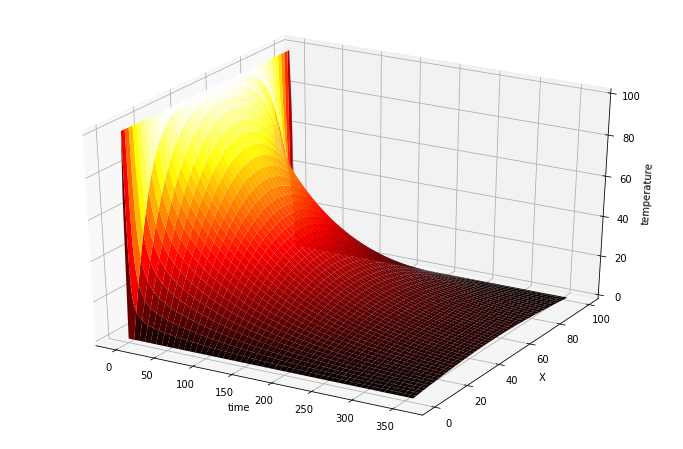

In [4]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(12,8))
t = np.arange(Nsteps//store_every)*sim.dt
x = np.arange(Ngrid)*sim.dx

X, TIME = np.meshgrid(x, t)

ax.plot_surface(TIME, X, T_store, cmap='hot')
ax.set(xlabel='time', ylabel='X', zlabel='temperature')

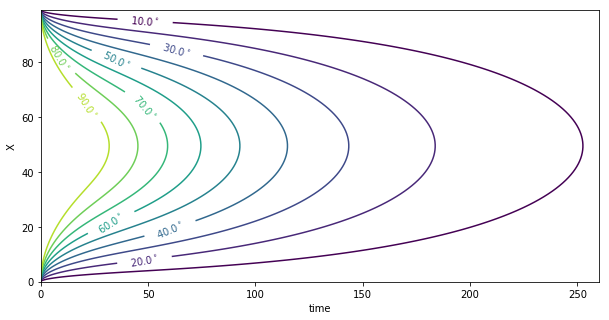

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
C = ax.contour(TIME, X, T_store, levels=np.arange(1,11)*10)
plt.clabel(C, fmt='$%1.1f^\circ$')
ax.set(xlabel='time', ylabel='X')
ax.set_xlim([0,260]);

Let's compare this to the analytic solution of the 1D heat equation. For an overview of solving the heat equation using separation of variables, [see here](https://ocw.mit.edu/courses/mathematics/18-303-linear-partial-differential-equations-fall-2006/lecture-notes/heateqni.pdf). The solution to our problem is:

$$
\begin{equation}
T(x, t) = \dfrac{4T_0}{\pi} \sum_{n=1}^{\infty}
          \dfrac{\sin [(2n-1) \pi x/L)]}{2n-1}
          \exp \left(\dfrac{-(2n-1)^2\pi^2 \eta^2}{L^2} t \right)
\end{equation}
$$

This is a spectral solution, where the solution is a sum of Fourier modes with different decay rates. Higher frequency modes (higher $n$) decay faster than lower frequency modes (lower $n$). This makes sense, as our intuition is that hot things relax to equilibrium. We can truncate the solution to only include the lowest frequency mode:

$$
\begin{equation}
T(x, t) \approx \dfrac{4T_0}{\pi}
          \sin \left (\dfrac{\pi x}{L} \right)
          \exp \left(\dfrac{-\pi^2 \eta^2}{L^2} t \right)
\end{equation}
$$

This approximation becomes more valid as time goes on (after higher frequency modes have substantially decayed), specifically when

$$
\begin{equation}
t > \dfrac{L^2}{\eta^2 \pi^2}
\end{equation}
$$

Let's plot the temperature at the center of the bar, $x = L/2$, as a function of time and compare it to this equation.

[Text(0, 0.5, 'temperature'), Text(0.5, 0, 'time')]

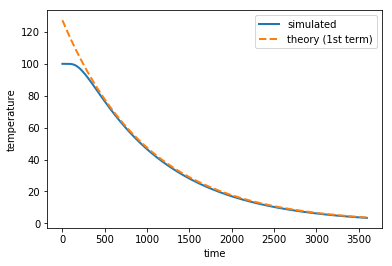

In [6]:
fig, ax = plt.subplots()

time = sim.dt*np.arange(Nsteps)[::store_every]
ax.plot(time, T_store[:,50], lw=2, label='simulated')

L = sim.dx*len(sim.T)
eta = sim.eta
x = L/2
T_theory = 4*100/np.pi*np.sin(np.pi/2)*np.exp(-np.pi**2/L**2*time)
ax.plot(time, T_theory, '--', lw=2, label='theory (1st term)')

ax.legend()
ax.set(xlabel='time', ylabel='temperature')

We see that the first term theory agrees well with the simulation after about $t \approx 400$. To verify the simulation when $t < 400$, we can include more terms (up to $n=20)$:

[(80, 105), (0, 400)]

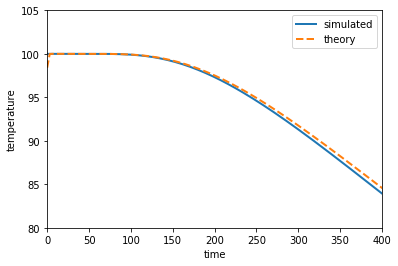

In [7]:
fig, ax = plt.subplots()

ax.plot(time, T_store[:,50], lw=2, label='simulated')

T_theory = np.zeros_like(T_store[:,50])
for n in range(1, 21):
    T_theory += 4*100/np.pi*np.sin((2*n-1)*np.pi/2)/(2*n-1)*np.exp(-(2*n-1)**2*np.pi**2/L**2*time)

ax.plot(time, T_theory, '--', lw=2, label='theory')

ax.legend()
ax.set(xlabel='time', ylabel='temperature')
ax.set(xlim=[0,400], ylim=[80,105])

We can also check the spatial distrubution at a fixed time $t = 50$:

[Text(0, 0.5, 'temperature'), Text(0.5, 0, 'X')]

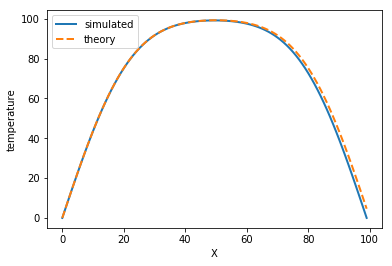

In [8]:
fig, ax = plt.subplots()

ti = 50
x = sim.dx*np.arange(Ngrid)
ax.plot(x, T_store[ti], lw=2, label='simulated')

T_theory = np.zeros_like(T_store[ti])
for n in range(1, 21):
    T_theory += 4*100/np.pi*np.sin((2*n-1)*np.pi*x/L)/(2*n-1)*np.exp(-(2*n-1)**2*np.pi**2/L**2*time[ti])

ax.plot(x, T_theory, '--', lw=2, label='theory')

ax.legend()
ax.set(xlabel='X', ylabel='temperature')

## Exercise 2

We'll define a function that does the following:

- Given a signal function and sampling, compute the fft using `np.rfft`
- Compute the approximation of the signal with inverse fft using `np.irfft`

In [9]:
def fourier_approx(f, L, N):
    """Approximate a function f by its Fourier expansion
    
    Arguments:
        f    f(x) function to Fourier transform
        L    length of x
        N    number of x samples
    
    Returns (x, frequency, dft, approximation)
    """
    x  = np.linspace(0, L, N)
    dx = x[1] - x[0]

    freq = np.fft.rfftfreq(x.shape[-1], d=dx)
    
    # Discrete Fourier transform
    A = np.fft.rfft(f(x))
    
    # Inverse Fourier transform
    approx = np.fft.irfft(A)
    
    return x, freq, A, approx

### Part 1

We then use this function on the square wave function. The first plot is the amplitude of the fft coefficients as a function of frequency. The second plot shows the Fourier expanded signal on top of the original signal.

[Text(0.5, 0, 'X')]

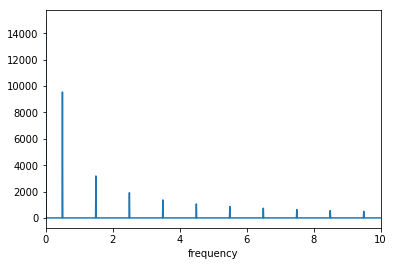

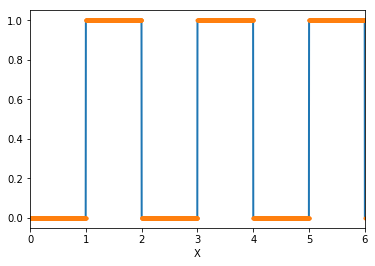

In [10]:
def square_wave(x):
    return np.floor(x) % 2

x, freq, A, approx = fourier_approx(square_wave, L=100, N=30000)

fig, ax = plt.subplots()
ax.plot(freq, np.abs(A))
ax.set_xlim([0,10])
ax.set(xlabel='frequency')

fig, ax = plt.subplots()
ax.plot(x, square_wave(x), lw=2)
ax.plot(x, approx, 'o', ms=3)
ax.set_xlim([0,6])
ax.set(xlabel='X')

### Part 2

[Text(0.5, 0, 'X')]

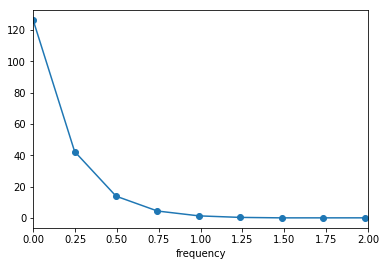

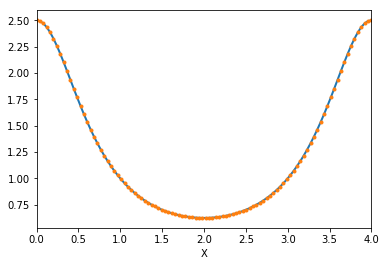

In [11]:
def f(x):
    L = 4
    return 1/(1 - 0.6*np.cos(2*np.pi*x/L))

x, freq, A, approx = fourier_approx(f, L=4, N=100)

fig, ax = plt.subplots()
ax.plot(freq, np.abs(A), '-o')
ax.set_xlim([0,2])
ax.set(xlabel='frequency')

fig, ax = plt.subplots()
ax.plot(x, f(x), lw=2)
ax.plot(x, approx, 'o', ms=3)
ax.set_xlim([0,4])
ax.set(xlabel='X')

### Part 3

[Text(0.5, 0, 'X')]

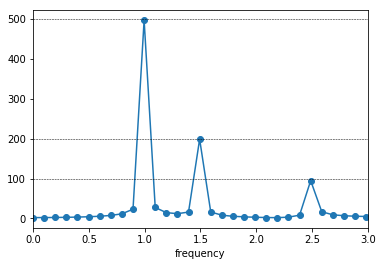

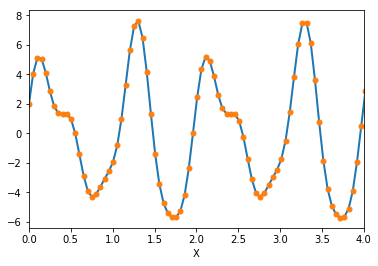

In [12]:
def f(x):
    L = 1
    return 5*np.sin(2*np.pi*x/L) + 2*np.cos(3*np.pi*x/L) + np.sin(5*np.pi*x/L)

x, freq, A, approx = fourier_approx(f, L=10, N=200)

fig, ax = plt.subplots()
ax.plot(freq, np.abs(A), '-o')
ax.set_xlim([0,3])
ax.set(xlabel='frequency')

for y in [100, 200, 500]:
    ax.axhline(y, color='k', ls='--', lw=.5)

fig, ax = plt.subplots()
ax.plot(x, f(x), lw=2)
ax.plot(x, approx, 'o', ms=5)
ax.set_xlim([0,4])
ax.set(xlabel='X')

We can see what happens in this example if we truncate the higher frequencies. Including only frequencies below 2:

[Text(0.5, 0, 'X')]

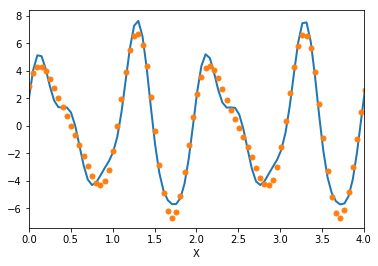

In [13]:
fig, ax = plt.subplots()
ax.plot(x, f(x), lw=2)

x, freq, A, approx = fourier_approx(f, L=10, N=200)
A[freq > 2] = 0
approx = np.fft.irfft(A)
ax.plot(x, approx, 'o', ms=5)
ax.set_xlim([0,4])
ax.set(xlabel='X')

And only frequencies below 1.25:

[Text(0.5, 0, 'X')]

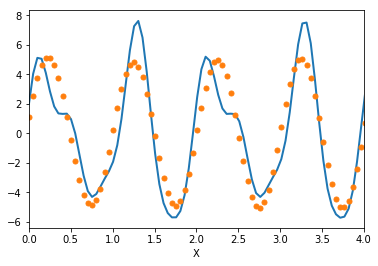

In [14]:
fig, ax = plt.subplots()
ax.plot(x, f(x), lw=2)

x, freq, A, approx = fourier_approx(f, L=10, N=200)
A[freq > 1.25] = 0
approx = np.fft.irfft(A)
ax.plot(x, approx, 'o', ms=5)
ax.set_xlim([0,4])
ax.set(xlabel='X')

The lowest frequency mode gives a pure sine function that best fits the original signal.